## CNN

In [86]:
# オープンソース
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torch.nn import Conv2d
from torch.utils.data import DataLoader
# 自作
import utils

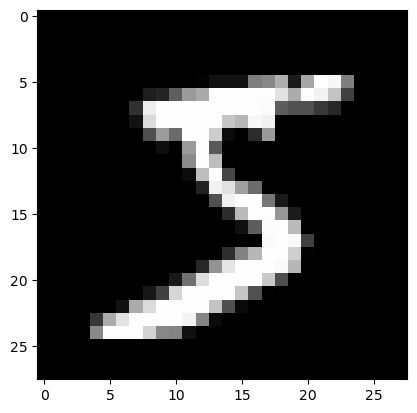

In [60]:
# MINISTデータセット
dataset = torchvision.datasets.MNIST('~/data', train=True, download=True)
im, label = dataset[0]
# PIL -> Tensorに変換
transform = transforms.ToTensor()
im = transform(im)
# 3rank -> 2rankに変換(grayスケールなので)
im = im[0, :, :]

plt.imshow(im, cmap='gray')

### スクラッチ実装

In [61]:
# filter作成
top_edge_filter = torch.tensor([[-1, -1, -1],
                                [0, 0, 0],
                                [1, 1, 1]])
left_edge_filter = torch.tensor([[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]])

In [62]:
im_h, im_w = im.shape
f_h, f_w = top_edge_filter.shape
print(im_h, im_w)
print(f_h, f_w)

28 28
3 3


In [63]:
def apply_filter(im, filter):
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

torch.Size([26, 26])


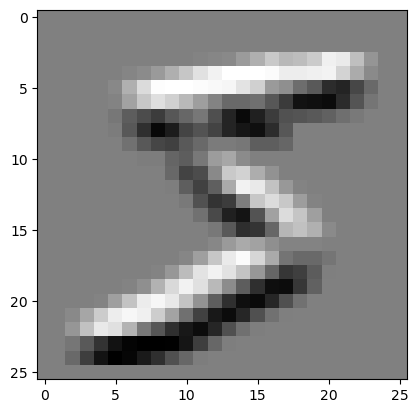

In [64]:
filterd_im = apply_filter(im, top_edge_filter)
print(filterd_im.shape)
plt.imshow(filterd_im, cmap='gray')

torch.Size([26, 26])


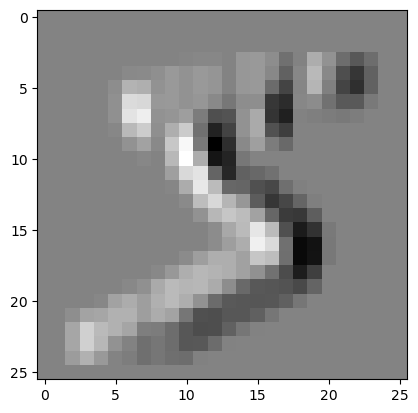

In [65]:
filterd_im = apply_filter(im, left_edge_filter)
print(filterd_im.shape)
plt.imshow(filterd_im, cmap='gray')

### CNN構築

In [71]:
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x4x4
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4 -> 32x2x2
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> 128x1x1
    nn.Flatten(),
    # 128x1x1 -> 10x1x1
    nn.Linear(128, 10)
)

In [73]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

### MNISTデータセットの学習

In [88]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
train_dataset = torchvision.datasets.MNIST('~/data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('~/data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conv_model = conv_model.to(device)
opt = optim.SGD(conv_model.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)

Training:   0%|          | 0/469 [00:00<?, ?it/s]

epoch: 0: train error: 0.15324327322656411, validation error: 0.1434076412498385, validation accuracy: 0.9545094936708861


epoch: 1: train error: 0.1374824657551706, validation error: 0.1760012136324297, validation accuracy: 0.942939082278481


epoch: 2: train error: 0.12671167184231377, validation error: 0.116175839294314, validation accuracy: 0.9613330696202531


epoch: 3: train error: 0.11784701964764326, validation error: 0.10191567303742506, validation accuracy: 0.9657832278481012


epoch: 4: train error: 0.10956286097656308, validation error: 0.12533687807831773, validation accuracy: 0.9581685126582279


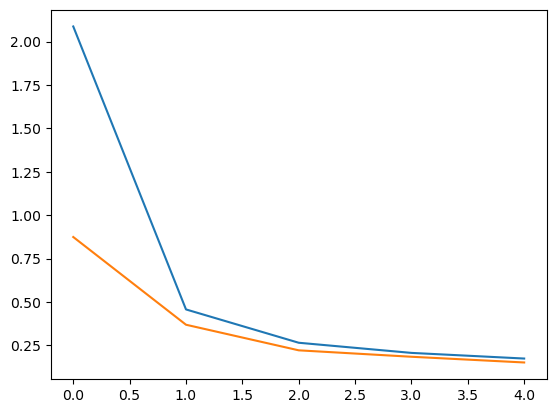

In [90]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')